# Google Sheets Scraper
Goal: scrape the Google Sheet with autofilling data from the Particle Electron at Carlsbad Aquafarm
[Google Sheet named "SeapHOx_OuterLagoon" is here](https://docs.google.com/spreadsheets/d/19jxQzqJa_B5zZJJmd6LmJDA0utKn0NTWoeNK_HkOse4/edit#gid=0)

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datasheets
import os

%matplotlib inline

### Scrape Google Sheets
Use datasheets library, following directions from https://datasheets.readthedocs.io/en/latest/index.html


In [2]:
client = datasheets.Client()
workbook = client.fetch_workbook('SeapHOx_OuterLagoon')
tab = workbook.fetch_tab('Sheet1')
electron_array = tab.fetch_data()
electron_array.head()

,Timestamp,name,email,phone,message
0,2018-04-17,"2018/04/17,18:30:25,18.860,0.07985,-0.83308,5....",undefined,undefined,undefined
1,2018-04-17,"2018/04/17,19:00:25,18.870,0.08055,-0.83331,5....",undefined,undefined,undefined
2,2018-04-17,"2018/04/17,19:30:25,18.860,0.08002,-0.83326,5....",undefined,undefined,undefined
3,2018-04-17,"2018/04/17,20:02:20,18.860,0.07946,-0.83334,5....",undefined,undefined,undefined
4,2018-04-17,"2018/04/17,20:32:51,18.850,0.07959,-0.83293,5....",undefined,undefined,undefined


### Get SeapHOx String, Parse, Remove Bad Transmissions

In [3]:
data_col = electron_array.iloc[:, 1]
data_array = pd.DataFrame(data_col.str.split(',', expand = True)) 

# Get rid of rows that don't start with "20" as in "2018"; this is foolproof until 2100 or 20 shows up elsewhere in a bad row, I guess
good_rows = (data_array.iloc[:, 0]).str.contains('20')
good_rows.fillna(False, inplace = True)
data_array = data_array[good_rows]

### Rename and Reindex

In [4]:
data_array.columns = ['Date', 'Time', 'V_batt', 'V_int', 'V_ext', 'P_dbar', 'pH_int', 'O2_uM', 'temp_SBE', 'sal_SBE', 'V_batt_elec', 'charge_status']
data_array.set_index(pd.to_datetime(data_array['Date'] + ' ' + data_array['Time']), inplace = True)
data_array.drop(['Date', 'Time'], axis = 1, inplace = True)
data_array.head()

,V_batt,V_int,V_ext,P_dbar,pH_int,O2_uM,temp_SBE,sal_SBE,V_batt_elec,charge_status
2018-04-17 18:30:25,18.860,0.07985,-0.83308,5.33600,8.05349,328.51599,13.43740,33.55860,4.05,84.77
2018-04-17 19:00:25,18.870,0.08055,-0.83331,5.41600,8.08004,328.32300,13.48790,33.56140,4.05,84.62
2018-04-17 19:30:25,18.860,0.08002,-0.83326,5.38800,8.07537,325.82300,13.53800,33.55890,4.05,84.62
2018-04-17 20:02:20,18.860,0.07946,-0.83334,5.35400,8.06744,324.28900,13.54920,33.56210,4.05,84.48
2018-04-17 20:32:51,18.850,0.07959,-0.83293,5.21900,8.06995,326.27499,13.65300,33.56350,4.05,84.48


### Filter
- Filter based on date
- Cast to type float (for some reason the str.split leaves it as arbitrary object)
- This was necessary in early notebook as the input data wasn't filtered at all but the Google Sheet should be cleaner to begin with (*i.e.*, no land data)
- Filtration may come in handy later so keep this here for now

In [9]:
date_filt = data_array.index > '2018-09-07 18:30:00'
data_filt = data_array[date_filt]

import pytz
pacific = pytz.timezone('US/Pacific')
data_filt.index = data_filt.index.tz_localize(pytz.utc).tz_convert(pacific)

data_filt = data_filt.astype('float')

data_filt.tail()
# data_filt.V_press

,V_batt,V_int,V_ext,P_dbar,pH_int,O2_uM,temp_SBE,sal_SBE,V_batt_elec,charge_status
2018-10-01 00:11:51-07:00,15.99,0.05958,-0.94152,4.482,7.97889,537.96002,20.6200,34.2630,3.82,49.62
2018-10-01 07:04:43-07:00,15.96,0.03226,-0.97704,4.706,7.51540,641.47998,19.9832,34.0001,3.81,48.86
2018-10-01 12:00:20-07:00,15.98,0.06097,-0.94083,5.172,8.00754,656.64001,20.1543,34.2519,3.82,48.09
2018-10-01 13:00:20-07:00,15.98,0.06109,-0.93686,5.266,8.00922,657.12000,20.2398,34.1985,3.81,47.71
2018-10-01 14:00:20-07:00,15.98,0.06137,-0.93785,5.300,8.01331,663.94000,20.2593,34.1892,3.82,47.71


### Plot

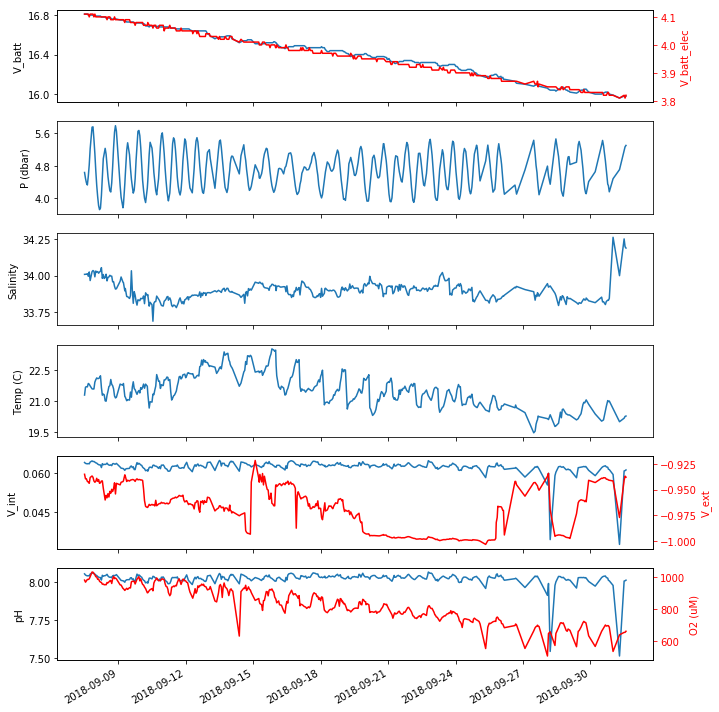

In [10]:
fig, axs = plt.subplots(6, 1, figsize = (10, 10), sharex = True)
axs[0].plot(data_filt.index, data_filt.V_batt)
axs[0].set_ylabel('V_batt')
ax2 = axs[0].twinx()
ax2.plot(data_filt.index, data_filt.V_batt_elec, 'r')
ax2.set_ylabel('V_batt_elec', color='r')
ax2.tick_params('y', colors='r')

axs[1].plot(data_filt.index, data_filt.P_dbar)
axs[1].set_ylabel('P (dbar)')

axs[2].plot(data_filt.index, data_filt.sal_SBE)
axs[2].set_ylabel('Salinity')

axs[3].plot(data_filt.index, data_filt.temp_SBE)
axs[3].set_ylabel('Temp (C)')

axs[4].plot(data_filt.index, data_filt.V_int)
axs[4].set_ylabel('V_int')
ax2 = axs[4].twinx()
ax2.plot(data_filt.index, data_filt.V_ext, 'r')
ax2.set_ylabel('V_ext', color='r')
ax2.tick_params('y', colors='r')

axs[5].plot(data_filt.index, data_filt.pH_int)
axs[5].set_ylabel('pH')
ax2 = axs[5].twinx()
ax2.plot(data_filt.index, data_filt.O2_uM, 'r')
ax2.set_ylabel('O2 (uM)', color='r')
ax2.tick_params('y', colors='r')

axs[0].xaxis_date() # make sure it knows that x is a date/time

for axi in axs.flat:
#     axi.xaxis.set_major_locator(plt.MaxNLocator(3))
#     print(axi)
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
#     axi.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.02f"))

fig.autofmt_xdate() # makes the date labels easier to read.
plt.tight_layout()
plt.savefig('test_dep_01.png')

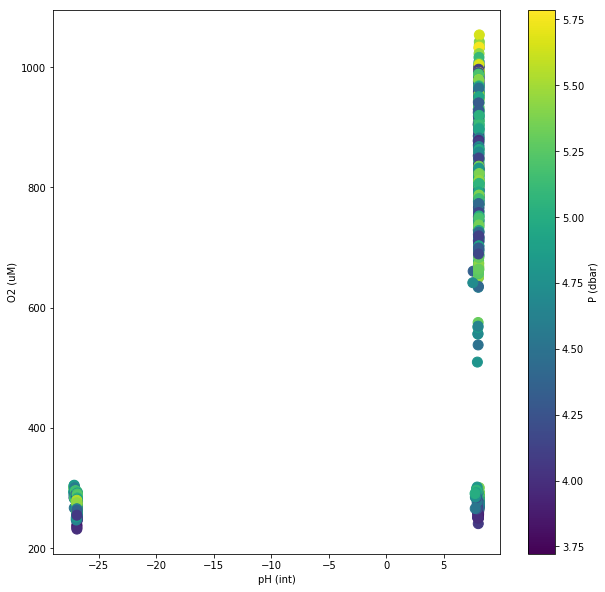

In [7]:
fig, axs = plt.subplots(1, 1, figsize = (10, 10), sharex = True)
pHOx = axs.scatter(x = data_filt.pH_int, 
                   y = data_filt.O2_uM, 
                   c = data_filt.P_dbar, 
                   s = 100)
axs.set_xlabel('pH (int)')
axs.set_ylabel('O2 (uM)')
plt.colorbar(pHOx, label = 'P (dbar)');

In [8]:
cmap = plt.get_cmap('coolwarm')
corr = data_filt.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("SeapHOx Correlations")\
    .set_precision(2)

,V_batt,V_int,V_ext,P_dbar,pH_int,O2_uM,temp_SBE,sal_SBE,V_batt_elec,charge_status
V_batt,1,0.56,0.51,0.027,0.57,0.81,-0.16,0.32,0.92,0.86
V_int,0.56,1,0.99,-0.012,1,0.46,-0.2,-0.032,0.58,0.6
V_ext,0.51,0.99,1,-0.018,0.99,0.35,-0.099,-0.1,0.49,0.5
P_dbar,0.027,-0.012,-0.018,1,-0.011,0.071,-0.2,-0.12,0.048,0.043
pH_int,0.57,1,0.99,-0.011,1,0.48,-0.21,-0.021,0.59,0.61
O2_uM,0.81,0.46,0.35,0.071,0.48,1,-0.57,0.43,0.96,0.97
temp_SBE,-0.16,-0.2,-0.099,-0.2,-0.21,-0.57,1,-0.04,-0.44,-0.49
sal_SBE,0.32,-0.032,-0.1,-0.12,-0.021,0.43,-0.04,1,0.41,0.43
V_batt_elec,0.92,0.58,0.49,0.048,0.59,0.96,-0.44,0.41,1,0.99
charge_status,0.86,0.6,0.5,0.043,0.61,0.97,-0.49,0.43,0.99,1
